In [1]:
# ! pip install sklearn-crfsuite
# ! pip install hyperopt
# ! pip install hyperas
import os
import time
import warnings
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn_crfsuite import CRF, metrics
from IPython.display import display, clear_output

import hyperas
import hyperopt
from hyperas.distributions import uniform
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperas import optim

os.chdir(os.getcwd())
warnings.filterwarnings('ignore')

# Final Pre-Processing

In [2]:
def generate_input(df, features, show=True):
    
    X, y = [], []
    number_of_sentences = len(df.idx_sent.unique())
    
    for i, sentence_id in enumerate(df.idx_sent.unique()):
        if show: print(f'\rSentence: {i+1}/{number_of_sentences}', end='')
        
        sentence_data = df[df.idx_sent == sentence_id]

        X.append([sentence_data.loc[row, features].to_dict() for row in sentence_data.index])
        y.append(sentence_data['Negation_cue'].values)
    
    return X, y

In [3]:
train_data = pd.read_csv('Data/tmtrain.Preprocessed.csv', index_col=0)
dev_data = pd.read_csv('Data/tmdev.Preprocessed.csv', index_col=0)

# Feature Selection

In [4]:
all_features = ['Token', 'Lemma', 'POS', 'POS_TAG', 'Dependency_Head', 'Dependency_Label',
                'next', 'prev', 'trigram', 'prev_bigram', 'next_bigram', 'HECT', 'HECA']

In [5]:
def feature_ablation(all_features):
    
    best_scores = []
    order_of_removal = []
    features_to_use = all_features.copy()
    train_x, train_y = generate_input(train_data, features_to_use, False)
    dev_x, dev_y = generate_input(dev_data, features_to_use, False)
    
    while len(features_to_use) > 1:
        
        scores = []
        print('\n', features_to_use)

        for feature in features_to_use:
            
            temp_train_x = deepcopy(train_x)
            temp_dev_x = deepcopy(dev_x)
            
            for sentence in temp_train_x:
                for word in sentence:
                    del word[feature]
        
            for sentence in temp_dev_x:
                for word in sentence:
                    del word[feature]            
            
            # Build new classifier
            crf = CRF(algorithm='lbfgs',
                      c1=0.1,
                      c2=0.1,
                      max_iterations=100,
                      all_possible_transitions=True)
            try: crf.fit(temp_train_x, train_y)
            except AttributeError: pass

            # Measure performance
            prediction = crf.predict(temp_dev_x)
            score = metrics.flat_f1_score(dev_y, prediction, average='weighted', labels=list(crf.classes_))
            scores.append(score)
            print(score)

        # Remove worst feature
        best_scores.append(np.max(scores))
        index_worst_feature = np.argmax(scores)
        feature_to_delete = features_to_use[index_worst_feature]
        
        for sentence in train_x:
            for word in sentence:
                del word[feature_to_delete]
        
        for sentence in dev_x:
            for word in sentence:
                del word[feature_to_delete]
        
        # Save progress
        order_of_removal.append(feature_to_delete)
        features_to_use.remove(feature_to_delete)
    
    return order_of_removal, best_scores

In [6]:
order_of_removal, best_scores = feature_ablation(all_features)


 ['Token', 'Lemma', 'POS', 'POS_TAG', 'Dependency_Head', 'Dependency_Label', 'next', 'prev', 'trigram', 'prev_bigram', 'next_bigram', 'HECT', 'HECA']
0.9972501448476203
0.9972501448476203
0.9971781438385873
0.9972501448476203
0.9971781438385873
0.9972501448476203
0.9971781438385873
0.9972501448476203
0.9970976414723567
0.9970976414723567
0.9971781438385873
0.9971781438385873
0.9966703372147931

 ['Lemma', 'POS', 'POS_TAG', 'Dependency_Head', 'Dependency_Label', 'next', 'prev', 'trigram', 'prev_bigram', 'next_bigram', 'HECT', 'HECA']
0.9972501448476203
0.9972501448476203
0.9972501448476203
0.9971781438385873
0.9972501448476203
0.9971781438385873
0.9972501448476203
0.9970976414723567
0.9970976414723567
0.9971063523377965
0.9970888227590222
0.9966703372147931

 ['POS', 'POS_TAG', 'Dependency_Head', 'Dependency_Label', 'next', 'prev', 'trigram', 'prev_bigram', 'next_bigram', 'HECT', 'HECA']
0.9971781438385873
0.9971781438385873
0.9972501448476203
0.9972501448476203
0.9972501448476203
0.99

In [7]:
order_of_removal

['Token',
 'Lemma',
 'Dependency_Head',
 'POS',
 'Dependency_Label',
 'next',
 'trigram',
 'next_bigram',
 'prev_bigram',
 'prev',
 'POS_TAG',
 'HECA']

In [8]:
best_scores

[0.9972501448476203,
 0.9972501448476203,
 0.9972501448476203,
 0.9972501448476203,
 0.9972501448476203,
 0.9972501448476203,
 0.9972501448476203,
 0.9974901654846495,
 0.9972061214913029,
 0.9965187397501329,
 0.995758461737477,
 0.995758461737477]

In [9]:
pd.DataFrame(order_of_removal).to_csv('order_of_removal2.csv', index=False)
pd.DataFrame(best_scores).to_csv('best_scores2.csv', index=False)

In [10]:
order_of_removal = pd.read_csv('order_of_removal2.csv')['0'].tolist()
best_scores = pd.read_csv('best_scores2.csv')['0'].tolist()

order_of_removal.reverse()
order_of_removal.append('Use all features')

best_scores.reverse()
best_scores.append(0.9972501448476203)

order_of_removal

['HECA',
 'POS_TAG',
 'prev',
 'prev_bigram',
 'next_bigram',
 'trigram',
 'next',
 'Dependency_Label',
 'POS',
 'Dependency_Head',
 'Lemma',
 'Token',
 'Use all features']

In [11]:
order_of_removal = ['HECA', 'POS-tag', 'Prev_token', 'Prev_bigram', 'Next_bigram', 'Trigram',
                    'Next_token',  'Dep_label', 'POS', 'Dep_head', 'Lemma', 'Token', 'Use all features']

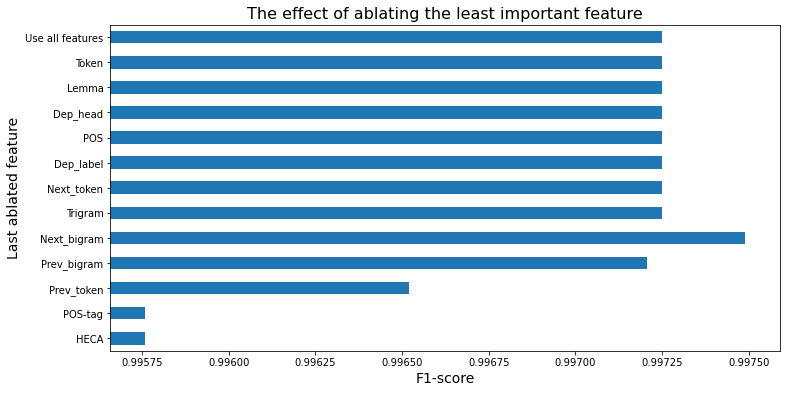

In [49]:
df_bar = pd.DataFrame({'F1-score': best_scores}, columns=['F1-score'], index=order_of_removal)

df_bar.plot.barh(figsize=(12,6),
                 legend=False,
                 xlim=(np.min(best_scores)-0.0001, np.max(best_scores)+0.0001))

plt.title('The effect of ablating the least important feature', size=16)
plt.xlabel('F1-score', size=14)
plt.ylabel('Last ablated feature', size=14)
plt.savefig('FAS_CRF.pdf')
plt.show()

In [13]:
features_to_use = ['HECT', 'HECA', 'POS_TAG', 'prev', 'prev_bigram']

print('Train data:')
train_x, train_y = generate_input(train_data, features_to_use)
print('\n\nDevelopment data:')
dev_x, dev_y = generate_input(dev_data, features_to_use)

Train data:
Sentence: 3644/3644

Development data:
Sentence: 787/787

In [17]:
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=True)
try: crf.fit(train_x, train_y)
except AttributeError: pass

prediction = crf.predict(dev_x)
metrics.flat_f1_score(dev_y, prediction, average='weighted', labels=list(crf.classes_))

0.9974901654846495

# HyperOpt

In [18]:
space = {'c1': hp.uniform('c1', 0.01, 0.99),
         'c2': hp.uniform('c2', 0.01, 0.99)}

def optimizer(space):
    
    crf = CRF(algorithm='lbfgs',
              c1=space['c1'],
              c2=space['c2'],
              max_iterations=100,
              all_possible_transitions=True)

    try: crf.fit(train_x, train_y)
    except AttributeError: pass
    
    prediction = crf.predict(dev_x)
    F1_score = metrics.flat_f1_score(dev_y, prediction, average='weighted', labels=list(crf.classes_))
    
    return {'loss': -F1_score, 'status': STATUS_OK}

CRF_trails = Trials()

CRF_best = fmin(fn=optimizer,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=CRF_trails)
CRF_best

100%|█████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/trial, best loss: -0.9974901654846495]


{'c1': 0.049750683223734174, 'c2': 0.1323605532276545}

In [26]:
crf = CRF(algorithm='lbfgs',
          c1=CRF_best['c1'],
          c2=CRF_best['c2'],
          max_iterations=100,
          all_possible_transitions=True)

try: crf.fit(train_x, train_y)
except AttributeError: pass

prediction = crf.predict(dev_x)
metrics.flat_f1_score(dev_y, prediction, average='weighted', labels=list(crf.classes_))

0.9974901654846495

In [27]:
metrics.flat_accuracy_score(dev_y, prediction)

0.9975676273310238

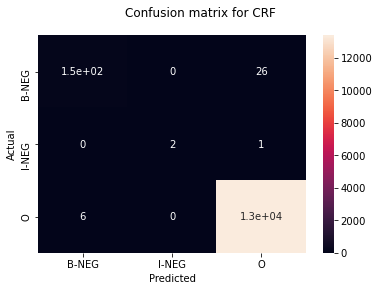

In [51]:
import seaborn as sns

def flatten(array):
    result = []
    for i in array: result.extend(i)
    return result

dev_y_flat = flatten(dev_y)
pred_flat = flatten(prediction)

confusion_matrix = pd.crosstab(pd.DataFrame(dev_y_flat)[0], pd.DataFrame(pred_flat)[0], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.suptitle('Confusion matrix for CRF')
plt.savefig('CM_CRF.pdf')
plt.show()

# Test data